In [74]:
!pip install feature_engine

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go

import datetime as dt

import subprocess
import sys
import os
# !{sys.executable} -m pip install feature_engine
# !{sys.executable} -m pip install kneed
# !{sys.executable} -m pip install wordcloud
import feature_engine

from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings("ignore")

from yellowbrick.cluster import SilhouetteVisualizer

from wordcloud import WordCloud

In [76]:
from matplotlib.font_manager import FontProperties
montserrat_font = FontProperties(fname="Montserrat-Regular.ttf")
nunito_font = FontProperties(fname="NunitoSans_10pt-Regular.ttf")
dream_font = FontProperties(fname="dreamorp.ttf")

In [77]:
df = pd.read_csv("cc_dirty.csv")

In [78]:
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,798000000000,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3.520000e+15,M,Digos,"169,393 people","Administrator, charities/voluntary organisations",31/08/1970,968000000000,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,628000000000,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
3,4.870000e+15,M,San Fernando,"121,812 people",NaN,18/07/1964,863000000000,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,$38.61
4,4.720000e+15,M,Laoag,"111,125 people",Dance movement psychotherapist,11/01/1954,257000000000,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69


In [79]:
df.nunique()

cc_num           69
gender            4
city             59
city_pop         60
job              90
dob              93
acct_num         89
acct_num2        89
trans_num    100000
unix_time     99881
category         14
amt           19963
dtype: int64

In [80]:
df['gender'].value_counts()

gender
M         73836
Male      31692
F          3812
Female     2537
Name: count, dtype: int64

In [81]:
df.columns

Index(['cc_num', 'gender', 'city', 'city_pop', 'job', 'dob', 'acct_num',
       'acct_num2', 'trans_num', 'unix_time', 'category', 'amt'],
      dtype='object')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     111877 non-null  float64
 1   gender     111877 non-null  object 
 2   city       111877 non-null  object 
 3   city_pop   111877 non-null  object 
 4   job        103427 non-null  object 
 5   dob        111877 non-null  object 
 6   acct_num   111877 non-null  int64  
 7   acct_num2  111877 non-null  int64  
 8   trans_num  111877 non-null  object 
 9   unix_time  111877 non-null  int64  
 10  category   103318 non-null  object 
 11  amt        111877 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 10.2+ MB


# Data Cleaning

## Fix Data Types

In [83]:
# Standardize the values in the "gender" column
df['gender'] = df['gender'].replace({'Male': 'M', 'Female': 'F'})

In [84]:
# Convert the "city_pop" column to strings
df['city_pop']=pd.to_numeric(df['city_pop'].str.replace('people', '').str.replace(',', ''), errors='coerce')

In [85]:
# Convert the "dob" column to the datetime data type
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

In [86]:
# Drop "acct_num2" and Convert the "acct_num" column to strings to remove exponential format
df.drop(columns="acct_num2", inplace=True)
df['acct_num'] = df['acct_num'].astype(str)

In [87]:
# Convert the "unix_time" column to datetime with format "mm/dd/yy"
df['unix_time'] = pd.to_datetime(df['unix_time'], unit='s')

In [88]:
# Convert the "price" column to float
df['amt']=pd.to_numeric(df['amt'].str.replace('$', '').str.replace(',', ''), errors='coerce')

## Check Null Values

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cc_num     111877 non-null  float64       
 1   gender     111877 non-null  object        
 2   city       111877 non-null  object        
 3   city_pop   111877 non-null  int64         
 4   job        103427 non-null  object        
 5   dob        45296 non-null   datetime64[ns]
 6   acct_num   111877 non-null  object        
 7   trans_num  111877 non-null  object        
 8   unix_time  111877 non-null  datetime64[ns]
 9   category   103318 non-null  object        
 10  amt        111877 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 9.4+ MB


In [90]:
job_null_count = df['job'].isnull().sum()
category_null_count = df['category'].isnull().sum()
total_null_count = df[['job', 'category']].isnull().sum().sum()


print("Total null values in 'job' column: {}".format(job_null_count.round(2)))
print("Total null values in 'category' column: {}".format(category_null_count.round(2)))
print("Total null values in 'job' and 'category' columns: {}".format(total_null_count.round(2)))

Total null values in 'job' column: 8450
Total null values in 'category' column: 8559
Total null values in 'job' and 'category' columns: 17009


In [91]:
# Compute number of rows with null value
print("Share of null values in 'job' column: {}%".format((100*(job_null_count/df.shape[0])).round(2)))
print("Share of null values in 'category' column: {}%".format((100*(category_null_count/df.shape[0])).round(2)))
print("Share of null values in 'job' and 'category' columns combined: {}%".format((100*(total_null_count/df.shape[0])).round(2)))

Share of null values in 'job' column: 7.55%
Share of null values in 'category' column: 7.65%
Share of null values in 'job' and 'category' columns combined: 15.2%


Dealing with Null Values: <br>
Since both 'job' and 'category' columns will not be used as main factors/variables to the study, we will retain null values and fill them with 'Not Indicated' values

In [92]:
# Replace null values in the "job" column with "No Job Indicated"
df['job'] = df['job'].fillna('No Job Indicated')
# Replace null values in the "category" column with "No Category Indicated"
df['category'].fillna('No Category Indicated', inplace=True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cc_num     111877 non-null  float64       
 1   gender     111877 non-null  object        
 2   city       111877 non-null  object        
 3   city_pop   111877 non-null  int64         
 4   job        111877 non-null  object        
 5   dob        45296 non-null   datetime64[ns]
 6   acct_num   111877 non-null  object        
 7   trans_num  111877 non-null  object        
 8   unix_time  111877 non-null  datetime64[ns]
 9   category   111877 non-null  object        
 10  amt        111877 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 9.4+ MB


In [94]:
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,798000000000,a72eaa86b043eed95b25bbb25b3153a1,2020-02-10 05:53:31,shopping_net,68.88
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",NaT,968000000000,060d12f91c13871a13963041736a4702,2020-05-31 05:29:28,entertainment,50.06
2,4.140000e+18,M,Calapan,133893,Financial controller,NaT,628000000000,18aafb6098ab0923886c0ac83592ef8d,2020-03-29 05:52:37,food_dining,105.44
3,4.870000e+15,M,San Fernando,121812,No Job Indicated,NaT,863000000000,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,food_dining,38.61
4,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,1954-11-01,257000000000,c20ee88b451f637bc6893b7460e9fee0,2020-09-28 08:35:59,gas_transport,82.69


# Check Duplicates

In [95]:
total_duplicates = df.duplicated().sum()
duplicates_share = ((total_duplicates)/df.shape[0])*100

print("Total Number of Duplicates: {}".format(total_duplicates))
print("Share of Duplicates: {}%".format(duplicates_share.round(2)))

Total Number of Duplicates: 11877
Share of Duplicates: 10.62%


In [96]:
#Drop duplicates since transactions should be unique
df.drop_duplicates(inplace=True)

In [97]:
df = df.reset_index(drop=True)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cc_num     100000 non-null  float64       
 1   gender     100000 non-null  object        
 2   city       100000 non-null  object        
 3   city_pop   100000 non-null  int64         
 4   job        100000 non-null  object        
 5   dob        40443 non-null   datetime64[ns]
 6   acct_num   100000 non-null  object        
 7   trans_num  100000 non-null  object        
 8   unix_time  100000 non-null  datetime64[ns]
 9   category   100000 non-null  object        
 10  amt        100000 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 8.4+ MB


New no. of rows: 100k

# Feature Engineering

In [99]:
# Calculate customer age from date_of_birth
#df['dob'] = pd.to_datetime(df['dob'])
#df['age'] = (pd.to_datetime('now') - df['dob']).astype('<m8[Y]')

#df['dob'] = pd.to_datetime(df['dob'])
df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y')
df['age'] = (df['unix_time']-df['dob'])
# Convert the age column to years only
df['age'] = df['age'].dt.days // 365 # Use integer division to get the whole number of years
df.head()

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt,age
0,6.760000e+11,M,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,798000000000,a72eaa86b043eed95b25bbb25b3153a1,2020-02-10 05:53:31,shopping_net,68.88,61.0
1,3.520000e+15,M,Digos,169393,"Administrator, charities/voluntary organisations",NaT,968000000000,060d12f91c13871a13963041736a4702,2020-05-31 05:29:28,entertainment,50.06,NaN
2,4.140000e+18,M,Calapan,133893,Financial controller,NaT,628000000000,18aafb6098ab0923886c0ac83592ef8d,2020-03-29 05:52:37,food_dining,105.44,NaN
3,4.870000e+15,M,San Fernando,121812,No Job Indicated,NaT,863000000000,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,food_dining,38.61,NaN
4,4.720000e+15,M,Laoag,111125,Dance movement psychotherapist,1954-11-01,257000000000,c20ee88b451f637bc6893b7460e9fee0,2020-09-28 08:35:59,gas_transport,82.69,65.0


In [100]:
# Extract Date, Month, and year of transactions
df['trans_date'] = df['unix_time'].dt.strftime('%Y-%m-%d')
df['trans_year'] = df['unix_time'].dt.strftime('%Y')
df['trans_month'] = df['unix_time'].dt.strftime('%b')

In [101]:
# Check for location behavior
df['is_ncr'] = df['city'].apply(lambda x: 1 if x in ['City of Parañaque','Malabon','Makati City','City of Calamba','Manila','Muntinlupa City','Olongapo','Valenzuela','Caloocan City','San Jose del Monte','Imus','San Juan','Mandaluyong City'] else 0)

In [102]:
# Separate net and pos data
df['gen_cat'] = df['category'].apply(lambda x: 'Net' if '_net' in x  else ('POS' if 'pos' in x else 'Other'))

# EDA

In [103]:
def set_chart_properties(title,x_label,y_label,legend_title):
    sns.set(style="whitegrid")
    # Set plot labels and title
    plt.xlabel(x_label,fontproperties=nunito_font, fontsize=14)
    plt.ylabel(y_label,fontproperties=nunito_font, fontsize=14)
    plt.title(title,fontproperties=dream_font, fontsize=20)

    # Show the legend
    plt.legend(title=legend_title, loc='upper right', prop=nunito_font)

    plt.xticks(fontproperties=nunito_font, fontsize=12)
    plt.yticks(fontproperties=nunito_font, fontsize=12)

    plt.grid(False)


# Descriptive Statistics

In [104]:
df.describe()

,cc_num,city_pop,dob,unix_time,amt,age,is_ncr
count,1.000000e+05,1.000000e+05,40443,100000,100000.000000,40443.000000,100000.000000
mean,3.768208e+17,4.542336e+05,1954-10-12 08:31:07.161189824,2020-12-28 05:59:06.253699840,70.292041,65.762728,0.163160
min,6.049060e+10,4.104100e+04,1930-02-04 00:00:00,2020-01-01 00:06:15,1.000000,49.000000,0.000000
25%,3.800000e+13,1.338930e+05,1949-05-12 00:00:00,2020-07-11 04:48:53.750000128,8.740000,56.000000,0.000000
50%,3.520000e+15,2.330400e+05,1955-12-08 00:00:00,2020-12-19 02:06:04.500000,49.160000,65.000000,0.000000
75%,4.620000e+15,3.537670e+05,1963-10-02 00:00:00,2021-06-22 14:51:27,85.442500,72.000000,0.000000
max,4.830000e+18,2.308800e+07,1970-07-02 00:00:00,2021-12-06 23:50:42,18039.810000,91.000000,1.000000
std,1.231884e+18,1.931346e+06,NaN,NaN,183.991890,11.411454,0.369513


# Age

In [105]:
df_agg = df[df['gen_cat'] != 'Other'].groupby(['acct_num']).agg({'age':'mean'}).reset_index()

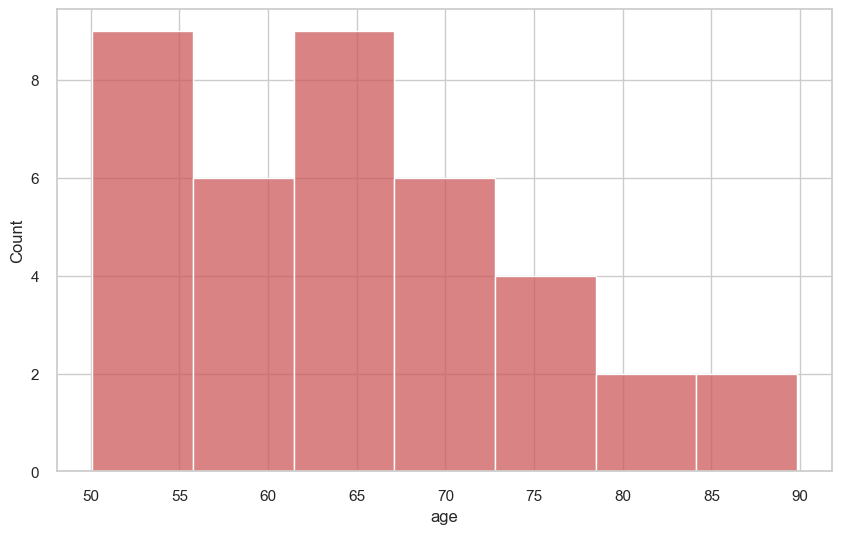

In [212]:
plt.figure(figsize=(10, 6))

sns.histplot(x='age', data=df_agg, color='#CD595B')

#set_chart_properties("Age Distribution","Age","Count","")

plt.show()

In [213]:
print("Age range is {} to {}, with a average value of {}".format(df_agg['age'].min(), df_agg['age'].max(),df_agg['age'].mean().round(2)))

Age range is 50.09090909090909 to 89.8298755186722, with a average value of 64.78


## Transactions per category YoY

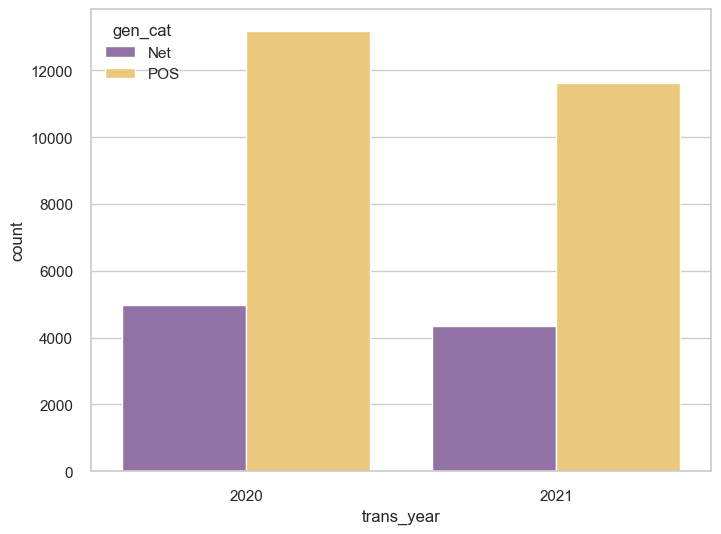

In [250]:
plt.figure(figsize=(8, 6))
bar_colors = ['#9468AC', '#FECE6B']

sns.countplot(x='trans_year', hue='gen_cat', data=df[df['gen_cat']!='Other'], palette=bar_colors)

#set_chart_properties("Transactions per Category (2020 vs. 2021)","Year","Transaction Count","Category")

plt.show()

In [251]:
df_pos_net = df[df['gen_cat']!='Other']

In [252]:
df_pos_net_agg  = df_pos_net.groupby(['trans_year','gen_cat']).agg({'trans_num':'count'}).reset_index()
df_pos_net_agg

,trans_year,gen_cat,trans_num
0,2020,Net,4985
1,2020,POS,13178
2,2021,Net,4359
3,2021,POS,11628


In [253]:
pos_2020 = df_pos_net_agg.loc[(df_pos_net_agg['trans_year'] == '2020') & (df_pos_net_agg['gen_cat'] == 'POS'), 'trans_num'].sum()
net_2020 = df_pos_net_agg.loc[(df_pos_net_agg['trans_year'] == '2020') & (df_pos_net_agg['gen_cat'] == 'Net'), 'trans_num'].sum()
result_2020 = pos_2020 / net_2020 - 1
print(" POS has {}% more purchases compared to Net in 2020".format(100*result_2020.round(2)))

 POS has 164.0% more purchases compared to Net in 2020


In [254]:
pos_2021 = df_pos_net_agg.loc[(df_pos_net_agg['trans_year'] == '2021') & (df_pos_net_agg['gen_cat'] == 'POS'), 'trans_num'].sum()
net_2021 = df_pos_net_agg.loc[(df_pos_net_agg['trans_year'] == '2021') & (df_pos_net_agg['gen_cat'] == 'Net'), 'trans_num'].sum()
result_2021 = pos_2021 / net_2021 - 1
print(" POS has {}% more purchases compared to Net in 2021".format(100*result_2021.round(2)))

 POS has 167.0% more purchases compared to Net in 2021


In terms of volume or number of transactions, POS or onsite transaction far exceeds number of Net or online transaction (more than 1.5x)

# Average Spent per Transaction

In [255]:
average_spent_per_category = df.groupby(['trans_year', 'gen_cat'])['amt'].mean().reset_index()

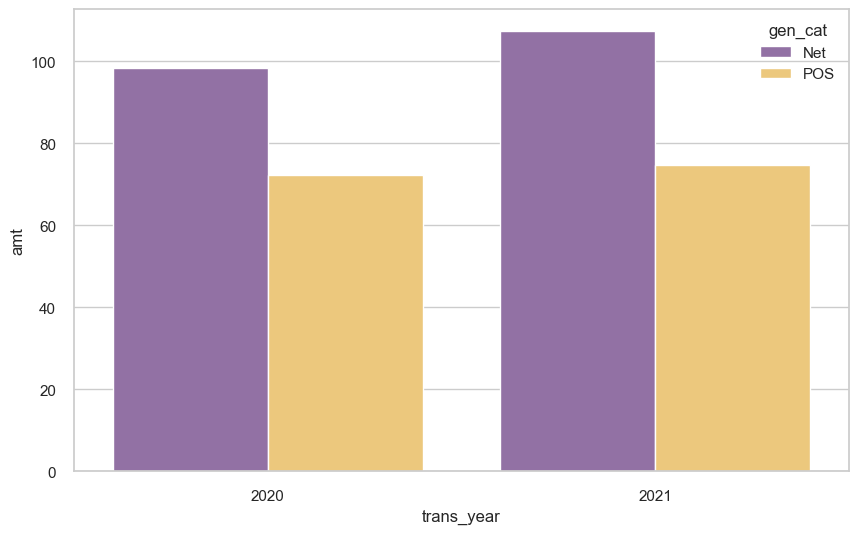

In [256]:
plt.figure(figsize=(10, 6))
bar_colors = ['#9468AC', '#FECE6B']

sns.barplot(x='trans_year', y='amt', hue='gen_cat', data=average_spent_per_category[average_spent_per_category['gen_cat']!='Other'], palette=bar_colors)

#set_chart_properties("Average Transaction Spent per Category (2020 vs. 2021)","Year","Spent","Category")

plt.show()

In [257]:
average_spent_per_category

,trans_year,gen_cat,amt
0,2020,Net,98.451862
1,2020,Other,64.104438
2,2020,POS,72.326088
3,2021,Net,107.352856
4,2021,Other,64.984150
5,2021,POS,74.729534


In [258]:
pos_2020 = average_spent_per_category.loc[(average_spent_per_category['trans_year'] == '2020') & (average_spent_per_category['gen_cat'] == 'POS'), 'amt'].sum()
net_2020 = average_spent_per_category.loc[(average_spent_per_category['trans_year'] == '2020') & (average_spent_per_category['gen_cat'] == 'Net'), 'amt'].sum()
result_2020 = net_2020/pos_2020 - 1
print("Customers are spending {}% higher on Net purchases vs POS in 2020".format(100*result_2020.round(2)))

Customers are spending 36.0% higher on Net purchases vs POS in 2020


In [259]:
pos_2021 = average_spent_per_category.loc[(average_spent_per_category['trans_year'] == '2021') & (average_spent_per_category['gen_cat'] == 'POS'), 'amt'].sum()
net_2021 = average_spent_per_category.loc[(average_spent_per_category['trans_year'] == '2021') & (average_spent_per_category['gen_cat'] == 'Net'), 'amt'].sum()
result_2021 = net_2021/pos_2021 - 1
print("Customers are spending {}% higher on Net purchases vs POS in 2021".format(100*result_2021.round(2)))

Customers are spending 44.0% higher on Net purchases vs POS in 2021


In terms of spending, average spent per transaction for Net purchases are almost 40% higher compared to POS

# Average Spent per Capita

In [260]:
spent_per_capita = df.groupby(['trans_year', 'gen_cat']).agg({'amt':'sum','acct_num':'nunique'}).reset_index()
spent_per_capita.rename(columns={'amt':'total_amount','acct_num':'unique_cust'}, inplace=True)

In [261]:
spent_per_capita['amt_per_cust'] = spent_per_capita['total_amount']/spent_per_capita['unique_cust']

In [262]:
spent_per_capita

,trans_year,gen_cat,total_amount,unique_cust,amt_per_cust
0,2020,Net,490782.53,73,6723.048356
1,2020,Other,2244680.99,72,31176.124861
2,2020,POS,953113.19,73,13056.345068
3,2021,Net,467951.10,82,5706.720732
4,2021,Other,2003721.27,82,24435.625244
5,2021,POS,868955.02,83,10469.337590


In [263]:
# Calculate quartiles and IQR
Q1 = df['amt'].quantile(0.25)
Q3 = df['amt'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers and create a new DataFrame
df_no_outliers = df[(df['amt'] >= lower_bound) & (df['amt'] <= upper_bound)]

In [264]:
spent_per_capita = df_no_outliers.groupby(['trans_year', 'gen_cat']).agg({'amt':'sum','acct_num':'nunique'}).reset_index()
spent_per_capita.rename(columns={'amt':'total_amount','acct_num':'unique_cust'}, inplace=True)

In [265]:
spent_per_capita['amt_per_cust'] = spent_per_capita['total_amount']/spent_per_capita['unique_cust']

In [266]:
spent_per_capita[spent_per_capita['gen_cat']!='Other']

,trans_year,gen_cat,total_amount,unique_cust,amt_per_cust
0,2020,Net,160388.59,67,2393.859552
2,2020,POS,575667.86,68,8465.703824
3,2021,Net,138990.63,67,2074.487015
5,2021,POS,497291.47,71,7004.105211


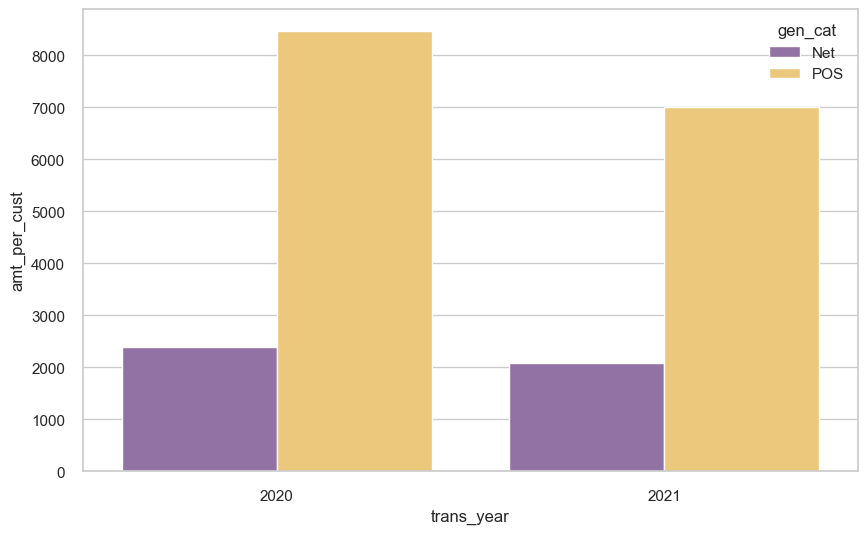

In [267]:
plt.figure(figsize=(10, 6))
bar_colors = ['#9468AC', '#FECE6B']

sns.barplot(x='trans_year', y='amt_per_cust', hue='gen_cat', data=spent_per_capita[spent_per_capita['gen_cat']!='Other'], palette=bar_colors)

#set_chart_properties("Average Spent per Capita (2020 vs. 2021)","Year","Spent","Category")

plt.show()

# Spend Analysis: Net vs. POS

Spent Per Transaction (Net > POS)
- Net custs tend to spend more money each time they make a transaction, which means that when they make a purchase, the amount spent is higher on average compared to POS custs This could imply that Net custs makes larger individual purchases or transactions.
<br>
<br>
Spend per Capita (POS > Net)
- This means that, on average, each person in POS group spends more money over a certain period than each person in Net group. This could be due to higher frequency of transactions (see trans graph).
<br>
<br>
Hypothesis:
- Net may represent customers who make occasional but substantial purchases, such as buying expensive items or services.
- POS may consist of a customer base who make more frequent but smaller purchases.
<br>
<br>
For the next steps, we need to gain deeper insights and understand underlying factors that can help the business tailor their marketing strategies, product offerings, and customer engagement efforts to better serve the unique preferences and behaviors of each group

## Checking Significant Difference

In [268]:
import scipy.stats as stats

# Perform the Mann-Whitney U test
U_statistic, p_value = stats.mannwhitneyu(df_pos_net[df_pos_net['gen_cat']=='POS']['amt'], df_pos_net[df_pos_net['gen_cat']=='Net']['amt'], alternative='two-sided')

alpha = 0.05
if p_value < alpha:
    print(f'The difference between groups is significant (p-value: {p_value})')
else:
    print(f'The difference between groups is not significant (p-value: {p_value})')

The difference between groups is significant (p-value: 1.8909819625518947e-07)


Since p value < 0.05 we can say that the difference between Net v. POS is statistically meaningful and warrants further investigation

** note: mannwhitney for non-normal groups

# RFM Analysis

For a sample size of 89 customers, it was considered starting with 3 bins for each RFM component, which would give you 3^3 = 27 segments. This provides a reasonable level of granularity without creating an overwhelming number of segments.

## Filtered to Net Customers

In [269]:
df_net = df[df['gen_cat']=='Net']

In [270]:
df_net.describe()

,cc_num,city_pop,dob,unix_time,amt,age,is_ncr
count,9.344000e+03,9.344000e+03,3774,9344,9344.000000,3774.000000,9344.000000
mean,3.847142e+17,4.968969e+05,1955-01-21 21:56:45.405405440,2020-12-26 19:16:54.106164480,102.604198,65.484367,0.165240
min,6.049060e+10,4.104100e+04,1930-02-04 00:00:00,2020-01-01 08:54:01,1.000000,49.000000,0.000000
25%,3.800000e+13,1.338930e+05,1949-05-12 00:00:00,2020-07-10 09:44:41,5.190000,56.000000,0.000000
50%,3.520000e+15,2.330400e+05,1957-05-04 00:00:00,2020-12-18 07:00:38.500000,11.980000,64.000000,0.000000
75%,4.620000e+15,3.537670e+05,1965-11-10 00:00:00,2021-06-21 13:36:16.750000128,90.820000,72.000000,0.000000
max,4.830000e+18,2.308800e+07,1970-07-02 00:00:00,2021-12-06 11:56:43,2435.600000,91.000000,1.000000
std,1.244153e+18,2.165102e+06,NaN,NaN,222.082999,11.354918,0.371417


In [271]:
df_net.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9344 entries, 0 to 99988
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   cc_num       9344 non-null   float64       
 1   gender       9344 non-null   object        
 2   city         9344 non-null   object        
 3   city_pop     9344 non-null   int64         
 4   job          9344 non-null   object        
 5   dob          3774 non-null   datetime64[ns]
 6   acct_num     9344 non-null   object        
 7   trans_num    9344 non-null   object        
 8   unix_time    9344 non-null   datetime64[ns]
 9   category     9344 non-null   object        
 10  amt          9344 non-null   float64       
 11  age          3774 non-null   float64       
 12  trans_date   9344 non-null   object        
 13  trans_year   9344 non-null   object        
 14  trans_month  9344 non-null   object        
 15  is_ncr       9344 non-null   int64         
 16  gen_cat   

## Net: Rule based-RFM

In [272]:
from datetime import datetime, timedelta

snapshot_date = max(df_net['unix_time']) + timedelta(days=1)
snapshot_date

Timestamp('2021-12-07 11:56:43')

In [273]:
# Aggregate data on a 'acct_num' level and compute rfm
df_net_agg = df_net.groupby(['acct_num']).agg({
    'unix_time': lambda x: (snapshot_date - x.max()).days,
    'trans_num': 'count',
    'amt': ['sum']
})
df_net_agg.columns = ['Recency','Frequency','Monetary']

In [274]:
df_net_agg.head()

,Recency,Frequency,Monetary
acct_num,,,
124000000000,2,191,17534.76
138000000000,377,5,4514.41
169000000000,117,2,1591.51
170000000000,2,204,13218.10
201000000000,16,71,12037.09


In [275]:
# Check 1 day recency count
df_net[df_net['unix_time']>='2021-12-06 00:00:00']['acct_num'].nunique()

17

In [276]:
df_net_agg[df_net_agg['Recency']==1].sum()

Recency          17.00
Frequency      2743.00
Monetary     262589.43
dtype: float64

### Recency

In [277]:
recency_groups = pd.qcut(df_net_agg['Recency'],
                   q=3,
                   labels=[3, 2, 1])

df_net_agg = df_net_agg.assign(R=recency_groups.values)
df_net_agg.head()

,Recency,Frequency,Monetary,R
acct_num,,,,
124000000000,2,191,17534.76,3
138000000000,377,5,4514.41,1
169000000000,117,2,1591.51,1
170000000000,2,204,13218.10,3
201000000000,16,71,12037.09,1


### Frequency

In [278]:
frequency_groups = pd.qcut(df_net_agg['Frequency'],
                   q=3,
                   labels=[1,2,3])

df_net_agg = df_net_agg.assign(F=recency_groups.values)
df_net_agg.head()

,Recency,Frequency,Monetary,R,F
acct_num,,,,,
124000000000,2,191,17534.76,3,3
138000000000,377,5,4514.41,1,1
169000000000,117,2,1591.51,1,1
170000000000,2,204,13218.10,3,3
201000000000,16,71,12037.09,1,1


### Monetary

In [279]:
monetary_groups = pd.qcut(df_net_agg['Monetary'],
                   q=3,
                   labels=[1, 2, 3])

# Create new column M
df_net_agg = df_net_agg.assign(M=monetary_groups)
df_net_agg.head()

,Recency,Frequency,Monetary,R,F,M
acct_num,,,,,,
124000000000,2,191,17534.76,3,3,3
138000000000,377,5,4514.41,1,1,1
169000000000,117,2,1591.51,1,1,1
170000000000,2,204,13218.10,3,3,2
201000000000,16,71,12037.09,1,1,2


### Compute RFM Score

In [280]:
df_net_agg['RFM_Score'] = df_net_agg[['R','F','M']].sum(axis=1)
df_net_agg.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score
acct_num,,,,,,,
124000000000,2,191,17534.76,3,3,3,9
138000000000,377,5,4514.41,1,1,1,3
169000000000,117,2,1591.51,1,1,1,3
170000000000,2,204,13218.10,3,3,2,8
201000000000,16,71,12037.09,1,1,2,4


In [281]:
df_net_agg['RFM_Score'].max()

9

### RFM Level Function

In [282]:
def rfm_level(df):
    if df['RFM_Score'] >= 8:
        return 'Top'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 7)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
df_net_agg['RFM_Level'] = df_net_agg.apply(rfm_level, axis=1)

df_net_agg.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Level
acct_num,,,,,,,,
124000000000,2,191,17534.76,3,3,3,9,Top
138000000000,377,5,4514.41,1,1,1,3,Low
169000000000,117,2,1591.51,1,1,1,3,Low
170000000000,2,204,13218.10,3,3,2,8,Top
201000000000,16,71,12037.09,1,1,2,4,Middle


In [283]:
df_net_agg.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Level                                 
Low         166.2      65.4   7264.1    38
Middle       37.2      86.4   9863.4    18
Top           1.5     160.7  15307.8    33

# Net: Kmeans Clustering

## Data Pre-processing

### Skewness

In [290]:
## Function to check skewness
def check_skew(df_skew, column):
    sns.set(style="whitegrid")
#    plt.xlabel(column, fontproperties=nunito_font, fontsize=14)
#    plt.ylabel('Density', fontproperties=nunito_font, fontsize=14)
    #    plt.title('Distribution of ' + column, fontproperties=dream_font, fontsize=20)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title('Distribution of ' + column, fontsize=20)

#    plt.xticks(fontproperties=nunito_font, fontsize=12)
#    plt.yticks(fontproperties=nunito_font, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(False)

    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    sns.distplot(df_skew[column], color='#9468AC')
    return

Recency's: Skew: 2.4482052300900645, : SkewtestResult(statistic=6.466407073856728, pvalue=1.0036049557114652e-10)
Frequency's: Skew: 0.564236124423987, : SkewtestResult(statistic=2.2017120534633974, pvalue=0.02768565475733012)
Monetary's: Skew: 0.9219396944160982, : SkewtestResult(statistic=3.3494775355767192, pvalue=0.000809641208265477)


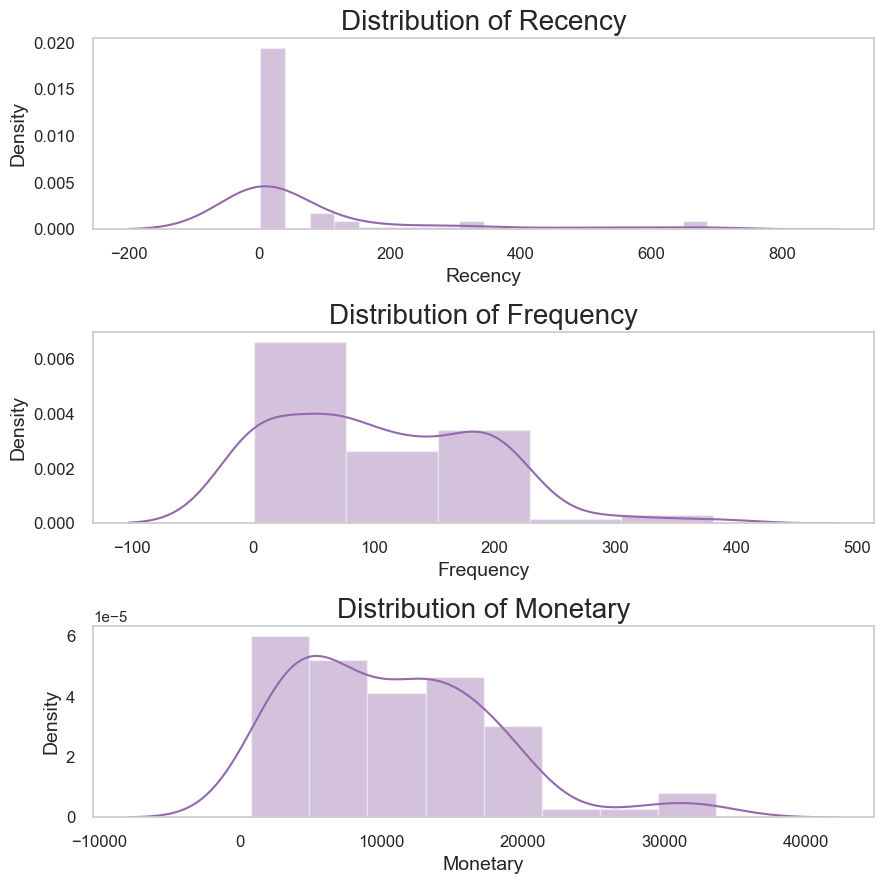

In [291]:
# Plot all 3 graphs together for summary findings

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_net_agg,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_net_agg,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_net_agg,'Monetary')

plt.tight_layout()

 - Recency's: The skewness of 2.448 suggests a right-skewed distribution. To make it more normally distributed, you can try applying a logarithmic transformation or a square root transformation to the data. You may also want to check for outliers and consider removing or transforming them.
<br><br>
- Frequency's: The skewness of 0.564 suggests a mild right skew. You can try a logarithmic transformation or a square root transformation to make it more normally distributed. Additionally, consider checking for outliers and addressing them if necessary.
<br><br>
 - Monetary's: The skewness of 0.922 indicates a moderate right skew. Similar to the other variables, you can apply a logarithmic transformation or a square root transformation to make it more normally distributed. Also, check for outliers and address them as needed.

### Data Transformation (Use Box-Cox)

### Log Transform

In [292]:
df_net_rfm_log = df_net_agg[['Recency','Frequency','Monetary']]

Recency's: Skew: 0.8190519656652074, : SkewtestResult(statistic=3.0414490825440343, pvalue=0.0023544238261903588)
Frequency's: Skew: -0.966572906191179, : SkewtestResult(statistic=-3.47782919758458, pvalue=0.0005054919167999027)
Monetary's: Skew: -0.7126895764975364, : SkewtestResult(statistic=-2.7044952192109553, pvalue=0.006840825407386016)


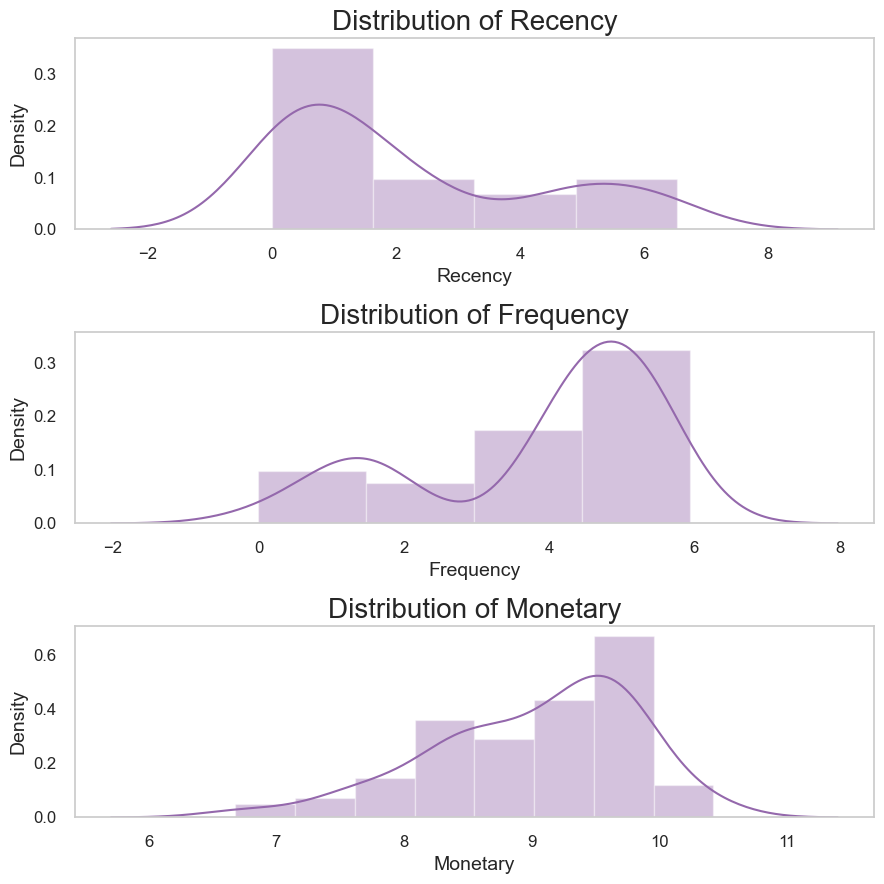

In [293]:
df_rfm_log = np.log(df_net_rfm_log)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

### Square root

In [294]:
df_net_rfm_sqrt = df_net_agg[['Recency','Frequency','Monetary']]
df_net_rfm_sqrt = np.sqrt(df_net_rfm_sqrt)

Recency's: Skew: 1.6623238670315916, : SkewtestResult(statistic=5.134164072535255, pvalue=2.8340078809133245e-07)
Frequency's: Skew: -0.2764921718639651, : SkewtestResult(statistic=-1.12414445936739, pvalue=0.26095174691291734)
Monetary's: Skew: 0.12790139647026075, : SkewtestResult(statistic=0.5259922169103997, pvalue=0.598893614685861)


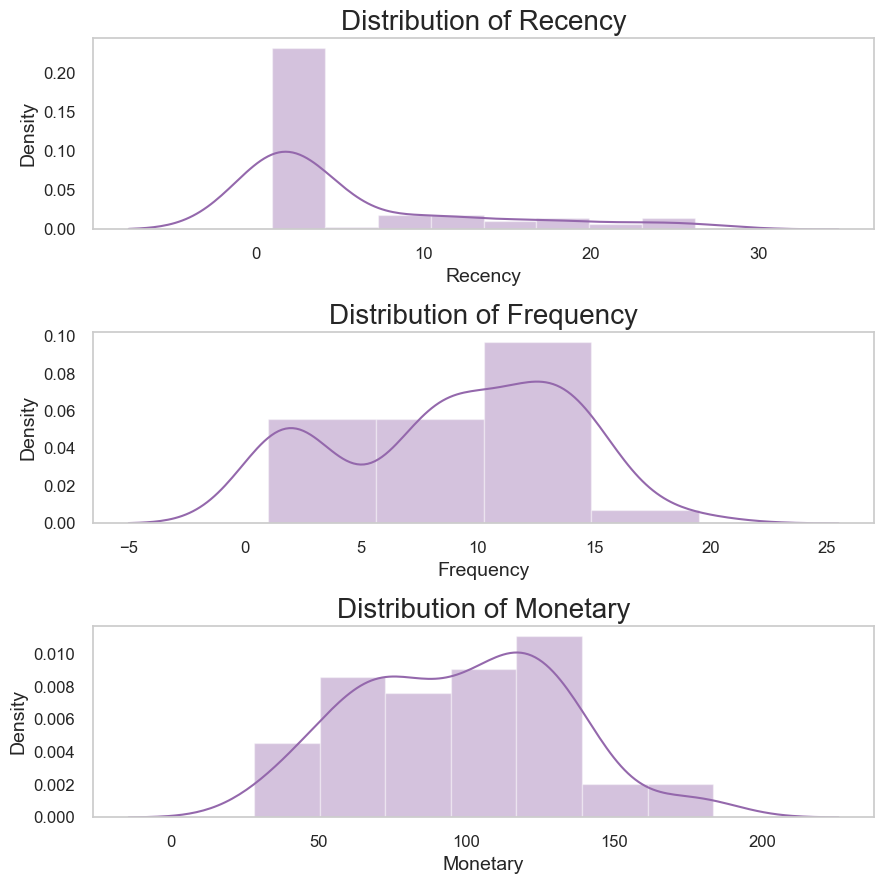

In [295]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_net_rfm_sqrt,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_net_rfm_sqrt,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_net_rfm_sqrt,'Monetary')

plt.tight_layout()

### Box cox

In [296]:
df_net_rfm_bc = df_net_agg[['Recency','Frequency','Monetary']]

df_net_rfm_bc['Recency'] = stats.boxcox(df_net_agg['Recency'])[0]
df_net_rfm_bc['Frequency'] = stats.boxcox(df_net_agg['Frequency'])[0]
df_net_rfm_bc['Monetary'] = stats.boxcox(df_net_agg['Monetary'])[0]

Recency's: Skew: 0.3024258645137551, : SkewtestResult(statistic=1.2261830639164182, pvalue=0.2201297931074947)
Frequency's: Skew: -0.3608293461925565, : SkewtestResult(statistic=-1.4527783770528833, pvalue=0.1462852974070756)
Monetary's: Skew: -0.06615262667891975, : SkewtestResult(statistic=-0.2726914539819764, pvalue=0.7850904045634588)


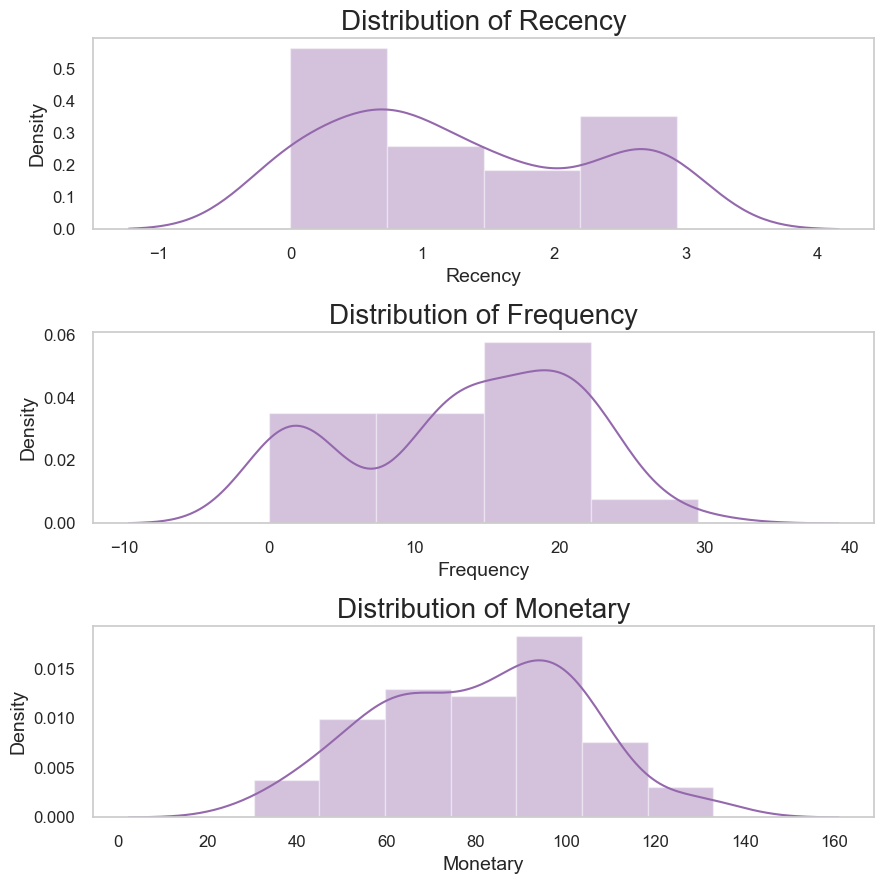

In [297]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_net_rfm_bc,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_net_rfm_bc,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_net_rfm_bc,'Monetary')

plt.tight_layout()

Among different transformations, Box-cox yielded the best results (skew near 0 and pvalue >0.05)

### Scaling

In [298]:
scaler = StandardScaler()
scaler.fit(df_net_rfm_bc)
rfm_net_table_scaled = scaler.transform(df_net_rfm_bc)

In [299]:
rfm_net_table_scaled_df = pd.DataFrame(rfm_net_table_scaled, columns=df_rfm_log.columns)
rfm_net_table_scaled_df.head()

,Recency,Frequency,Monetary
0,-0.671080,0.974203,0.996732
1,1.537646,-1.405167,-0.873997
2,1.287216,-1.600801,-1.783636
3,-0.671080,1.062543,0.524462
4,0.608523,-0.083369,0.378837


### KMeans

In [300]:
from sklearn.metrics import silhouette_score,  davies_bouldin_score
from scipy.spatial.distance import cdist
# distortions = []

wcss = {} ## Within-Cluster Sum of Square
ssc = {}
calinski_score = {}
davies_score = {}
K = range(2,10)

for k in K:
    #Building and fitting the model
    kmeans_model = KMeans(n_clusters=k, random_state=42).fit(rfm_net_table_scaled_df)
    kmeans_model.fit(rfm_net_table_scaled_df)

    wcss[k] = kmeans_model.inertia_ ### sum of squared distances to closest cluster center
    ssc[k] = silhouette_score(rfm_net_table_scaled_df, kmeans_model.labels_, metric='euclidean')
    davies_score[k] = davies_bouldin_score(rfm_net_table_scaled_df, kmeans_model.labels_)

### Identify Number of Clusters

### The Elbow Method (Cluster = 3)

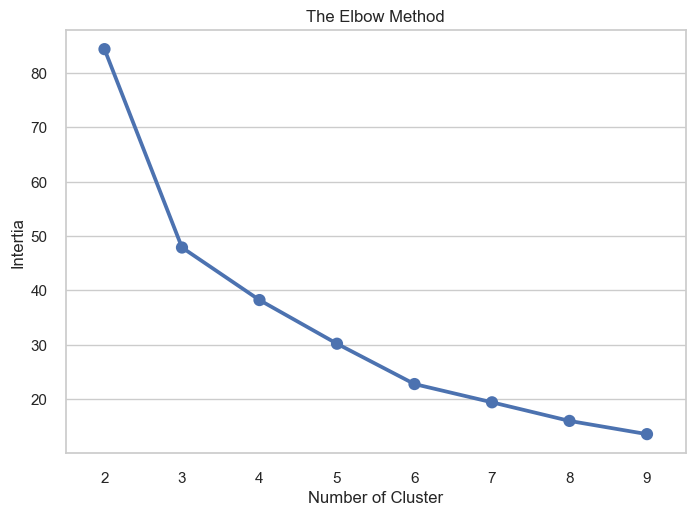

In [301]:
plt.title('The Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('Intertia')
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

In [302]:
from kneed import KneeLocator

cost_kneed = KneeLocator(x = K , y = list(wcss.values()) , S = 1.0 , curve = 'convex' , direction = 'decreasing' , online = True)
suggested_cluster = cost_kneed.elbow
print('Elbow at k = {} clusters'.format(suggested_cluster))

ModuleNotFoundError: No module named 'kneed'

### Silhouette Score (2 or 3)

In [ ]:
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('silhouette_score')
sns.pointplot(x=list(ssc.keys()), y=list(ssc.values()))
plt.show()

In [ ]:
def silhouette_plot(X , from_k , to_k):
    silhouette_scores = []
    for k in range(from_k , to_k):
        #Instantiate model in k clusters
        model = KMeans(n_clusters = k)
        #Instantiate Visualizer model of with k clusters
        visualizer = SilhouetteVisualizer(model)
        #Fit data to the model
        visualizer.fit(X)
        #Draw data
        visualizer.poof()
        #Append score
        silhouette_scores.append([visualizer.silhouette_score_ , k])
    return silhouette_scores

In [ ]:
silhouette_plot(rfm_net_table_scaled_df , 2 , 9)

Graph shows either 2 or 3 as best number of clusters - High Sil. coeff (nearer to 1) and high and above ave. individual/cluster sil. coef values

### Davies Bouldin Score (Cluster = 2)

In [ ]:
plt.title('Davies Bouldin Score')
plt.xlabel('clusters')
plt.ylabel('davies_score')
sns.pointplot(x=list(davies_score.keys()), y=list(davies_score.values()))
plt.show()

For Davies Bouldin Score, Cluster = 2 has the lowest score

### Visualization

### TSNE Graph

In [ ]:
def flattened_graph(normalised_df_rfm, clusters_number, original_df_rfm):

    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_

    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)

    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)

    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

    return df_new

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
df_rfm_k2 = flattened_graph(rfm_net_table_scaled_df, 2, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 2)
df_rfm_k3 = flattened_graph(rfm_net_table_scaled_df, 3, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 3)
df_rfm_k4 = flattened_graph(rfm_net_table_scaled_df, 4, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 4)
df_rfm_k5 = flattened_graph(rfm_net_table_scaled_df, 5, df_net_agg[['Recency','Frequency','Monetary']])

plt.tight_layout()

### Snake Plot

In [ ]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm['CustomerID'] = df_rfm_original.index
    normalised_df_rfm['Cluster'] = list(df_rfm_kmeans['Cluster'])

    # # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm,
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'],
                        var_name='Metric',
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')

    return

In [ ]:
plt.figure(figsize=(9, 9))
plt.subplot(4, 1, 1)
plt.title('Snake Plot of K-Means = 2')
snake_plot(rfm_net_table_scaled_df, df_rfm_k2, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 2)
plt.title('Snake Plot of K-Means = 3')
snake_plot(rfm_net_table_scaled_df, df_rfm_k3, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 3)

plt.title('Snake Plot of K-Means = 4')
snake_plot(rfm_net_table_scaled_df, df_rfm_k4, df_net_agg[['Recency','Frequency','Monetary']])

plt.subplot(4, 1, 4)
plt.title('Snake Plot of K-Means = 5')
snake_plot(rfm_net_table_scaled_df, df_rfm_k5, df_net_agg[['Recency','Frequency','Monetary']])

plt.tight_layout()

### Count Plot

In [ ]:
def countplot(cluster, cluster_number):
  original_scale = df_net_agg[['Recency','Frequency','Monetary']]
  original_scale['Cluster'] = list(cluster['Cluster'])

  sns.catplot(
    data=original_scale,
    x="Cluster",
    kind="count"
  )
  plt.show()

  return

In [ ]:
countplot(df_rfm_k2, 2)

In [ ]:
countplot(df_rfm_k3, 3)

In [ ]:
countplot(df_rfm_k4, 4)

In [ ]:
countplot(df_rfm_k5, 4)

Based on number of sample size (n=89), and resulting graphs, 3 is the best cluster.

In [ ]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)

    return df_new

In [ ]:
rfm_values(df_rfm_k3)

- Cluster 0 - High R, High F, High M (Active, Loyal, High Spender)
- Cluster 1 - Low R, Low F, Low M (Inactive, Not Loyal, Low Spender)
- Cluster 2 - High R, Low F, Low M (Active, Not Loyal, Low Spender)

### Interpretation

In [ ]:
interpret_cluster_result = df_net_agg
interpret_cluster_result['CustomerID'] = df_net_agg.index
interpret_cluster_result['Cluster'] = df_rfm_k3['Cluster']

In [ ]:
interpret_cluster_result.head()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
np.random.seed(0)
n_points = 100
x = list(interpret_cluster_result['Recency'])
y = list(interpret_cluster_result['Frequency'])
z = list(interpret_cluster_result['Monetary'])
c = list(interpret_cluster_result['Cluster'])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
scatter = ax.scatter(x, y, z, c=c, cmap="viridis")

# Label the axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')


# Set the plot title
plt.title('3D Scatter Plot')

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
sns.relplot(data=interpret_cluster_result,
            x="Recency",
            y="Frequency",
            hue="Cluster",
            size="Cluster"
            )
plt.show()

In [ ]:
sns.relplot(data=interpret_cluster_result,
            x="Recency",
            y="Monetary",
            hue="Cluster",
            size="Cluster"
            )
plt.show()

In [ ]:
sns.relplot(data=interpret_cluster_result,
            x="Frequency",
            y="Monetary",
            hue="Cluster",
            size="Cluster"
            )
plt.show()

### Boxplot

In [ ]:
interpret_cluster_result.loc[interpret_cluster_result['Cluster']==0, 'Cluster'] = 'Cluster 1'
interpret_cluster_result.loc[interpret_cluster_result['Cluster']==1, 'Cluster'] = 'Cluster 2'
interpret_cluster_result.loc[interpret_cluster_result['Cluster']==2, 'Cluster'] = 'Cluster 3'
interpret_cluster_result

In [ ]:
sns.catplot(
    data=interpret_cluster_result,
    x="Recency",
    y="Cluster",
    kind="box",
    sym="",
    order=["Cluster 1", "Cluster 2", "Cluster 3"],
    )
plt.show()

In [ ]:
sns.catplot(
    data=interpret_cluster_result,
    x="Frequency",
    y="Cluster",
    kind="box",
    sym="",
    order=["Cluster 1", "Cluster 2", "Cluster 3"]
    )
plt.show()

In [ ]:
sns.catplot(
    data=interpret_cluster_result,
    x="Monetary",
    y="Cluster",
    kind="box",
    sym="",
    order=["Cluster 1", "Cluster 2", "Cluster 3"]
    )
plt.show()

### Hypothesis Testing

In [ ]:
interpret_cluster_result = df_net_agg
interpret_cluster_result['CustomerID'] = df_net_agg.index
interpret_cluster_result['Cluster'] = df_rfm_k3['Cluster']

In [ ]:
from scipy.stats import f_oneway

# Perform ANOVA tests for each RFM variable
for rfm_variable in ['Recency', 'Frequency', 'Monetary']:
    # Extract data for each cluster
    cluster_data = [interpret_cluster_result[rfm_variable][interpret_cluster_result['Cluster'] == cluster]
                    for cluster in interpret_cluster_result['Cluster'].unique()]

    # Perform ANOVA test
    f_statistic, p_value = f_oneway(*cluster_data)

    # Output results
    print(f"ANOVA test for {rfm_variable}:")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("Statistically significant difference")
    else:
        print("No statistically significant difference")
    print("\n")


# Demographics Deep Dive

In [ ]:
df_net_agg[['CustomerID','Cluster']]

In [ ]:
df_pos_net.columns

In [ ]:
df_pos_net_dem = df_pos_net[['gender', 'city', 'city_pop', 'job', 'acct_num', 'age', 'is_ncr', 'gen_cat']]

In [ ]:
df_net_dem = df_pos_net_dem[df_pos_net_dem['gen_cat']=='Net'].drop_duplicates()

In [ ]:
df_net_dem

In [ ]:
merged_df = pd.merge(df_net_dem, df_net_agg[['CustomerID','Cluster']], on='acct_num', how='left')

In [ ]:
merged_df

In [ ]:
merged_df.value_counts('acct_num')

In [ ]:
merged_df[merged_df['acct_num']=='581000000000']

In [ ]:
merged_pop = merged_df[['city','city_pop','Cluster','acct_num','is_ncr']].drop_duplicates()

## Location

In [ ]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='is_ncr', data=merged_pop)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Place')

# Show the plot
plt.legend(title='Within NCR?')
plt.show()

In [ ]:
avg_pop = merged_pop[['city','city_pop','Cluster']].drop_duplicates()

In [ ]:
avg_pop.groupby('Cluster').mean()/1000

In [ ]:
# Number of cities within clusters
avg_pop.groupby('Cluster').size()

### Initial Demographics View
- Cluster 0 - Lower population area, Highly diverse cities
- Cluster 1 - Lower population area, Not as diverse cities (Concentrated)
- Cluster 2 - Highly populated area, Not as diverse cities (Concentrated)

In [ ]:
count_data = merged_df.groupby(['city', 'Cluster']).size().reset_index(name='Count')
count_data = count_data.sort_values(by='Count', ascending=False)

In [ ]:
# count_data[count_data['Cluster']==0]

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='Count', data=count_data[count_data['Cluster']==0])

# Add labels and a title
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per City (Cluster 1)')

plt.xticks(rotation=90)
# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='Count', data=count_data[count_data['Cluster']==1])

# Add labels and a title
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per City (Cluster 2)')

plt.xticks(rotation=90)
# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='city', y='Count', data=count_data[count_data['Cluster']==2])

# Add labels and a title
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per City (Cluster 3)')

plt.xticks(rotation=90)
# Show the plot
plt.show()

## Gender

In [ ]:
merged_gen = merged_df[['acct_num','gender','Cluster']].drop_duplicates()

In [ ]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='gender', data=merged_gen)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Gender')

# Show the plot
plt.legend(title='Gender')
plt.show()

In [ ]:
merged_gen.groupby(['Cluster','gender']).size()

## Job

In [ ]:
merged_job = merged_df[['acct_num','job','Cluster']].drop_duplicates()

In [ ]:
merged_job[merged_job['Cluster']==0].value_counts('job')

In [ ]:
job_0 = merged_job[merged_job['Cluster']==0]['job'].drop_duplicates().to_list()

In [ ]:
text_0 = ' '.join(job_0)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_0)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
merged_job[merged_job['Cluster']==0].value_counts('job')

Active, Loyal, and High Spender Group (First List):
- Diverse Professions: This group consists of individuals from various professions, some of which are likely to have higher incomes, such as investment banking and management consulting. Higher income levels can lead to more significant online spending.

- High Earnings: Some professions listed, such as investment banking and medical practice, tend to have higher income levels. This could mean that some individuals in this population have the financial means to be high spenders.

- Tech-Savvy: Many of the professions in this group may involve technology and internet usage, making them more comfortable with online shopping.

- Convenience-Seeking: Professionals with busy careers may prefer the convenience of online shopping, saving them time and effort.

- Unique Needs: Some professionals may have unique needs that can be better met through online shopping.

In [ ]:
job_1 = merged_job[merged_job['Cluster']==1]['job'].drop_duplicates().to_list()
text_1 = ' '.join(job_1)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_1)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
merged_job[merged_job['Cluster']==1].value_counts('job')

Low Spender, Low Loyalty, and Inactive Group (Second List):
- Job Characteristics: The job titles in this group may not be as closely related to high incomes or technology usage as those in the first list. For example, teachers and librarians may not typically have high disposable incomes.
- Limited Tech Engagement: Some professions in this group, like librarians and teachers, may involve less technology usage compared to the first group. This could lead to less familiarity with online shopping platforms.
- Less Discretionary Income: It's possible that individuals in this group have less discretionary income available for online shopping after meeting their basic needs and expenses.

In [ ]:
job_2 = merged_job[merged_job['Cluster']==2]['job'].drop_duplicates().to_list()
text_2 = ' '.join(job_2)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_2)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
merged_job[merged_job['Cluster']==2].value_counts('job')

Mid-Spender, Mid-Loyal, More Active
- Diverse Professions: Similar to the Cluster 0, this group comprises individuals from various professions, including finance (Accountant), education (Teacher), healthcare (Radiographer, Physicist, Medical), and technology (Programmer, Database Administrator), among others.

- Moderate Tech Engagement: While not as tech-centric as Cluster 0, many professions in this list involve moderate technology usage. This can make them more comfortable with online shopping compared to the Cluster 1.

- Income Levels: Individuals in this group may have varying income levels, with some professions potentially offering higher incomes (e.g., IT sales professional, Insurance broker) compared to Cluster 1. However,Cluster 0 includes potentially higher income levels and greater tech engagement.


## Category

In [ ]:
df_net_trans = df_pos_net[df_pos_net['gen_cat']=='Net']
merged_df_net_trans = pd.merge(df_net_trans, df_net_agg[['CustomerID','Cluster']], on='acct_num', how='left').drop_duplicates()

In [ ]:
merged_cat = merged_df_net_trans.groupby(['acct_num','category','Cluster']).agg({'CustomerID':'nunique'}).reset_index()

In [ ]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='category', data=merged_cat)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Category Purchases')

# Show the plot
plt.legend(title='Category')
plt.show()

## Age

In [ ]:
merged_age = merged_df[['acct_num','age','Cluster']].drop_duplicates()

In [ ]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=merged_age[merged_age['Cluster']==0], kde=True)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Age')
plt.xlim(50,100)
plt.ylim(0,10)

# Show the plot
plt.show()

In [ ]:
merged_age[merged_age['Cluster']==0]['age'].mean()

In [ ]:
merged_age[merged_age['Cluster']==0]['age'].min()

In [ ]:
merged_age[merged_age['Cluster']==0]['age'].max()

In [ ]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=merged_age[merged_age['Cluster']==1], kde=True)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Age')
plt.xlim(50,100)
plt.ylim(0,10)

# Show the plot
plt.show()

In [ ]:
merged_age[merged_age['Cluster']==1]['age'].mean()

In [ ]:
merged_age[merged_age['Cluster']==1]['age'].min()

In [ ]:
merged_age[merged_age['Cluster']==1]['age'].max()

In [ ]:
# Create a countplot
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=merged_age[merged_age['Cluster']==2], kde=True)

# Add labels and a title
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Number of Customers per Cluster per Age')
plt.xlim(50,100)
plt.ylim(0,10)

# Show the plot
plt.show()

In [ ]:
merged_age[merged_age['Cluster']==2]['age'].mean()

In [ ]:
merged_age[merged_age['Cluster']==2]['age'].min()

In [ ]:
merged_age[merged_age['Cluster']==2]['age'].max()